In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from tqdm import trange

In [2]:
parameter_names = ["Happiness Score", "Economy (GDP per Capita)", "Health (Life Expectancy)", "Freedom", "Trust (Government Corruption)", "Generosity"]
data_df = pd.read_csv("../data/world_happiness.csv")[parameter_names]

In [3]:
data_df

,Happiness Score,Economy (GDP per Capita),Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity
0,7.587,1.396510,0.941430,0.665570,0.419780,0.296780
1,7.561,1.302320,0.947840,0.628770,0.141450,0.436300
2,7.527,1.325480,0.874640,0.649380,0.483570,0.341390
3,7.522,1.459000,0.885210,0.669730,0.365030,0.346990
4,7.427,1.326290,0.905630,0.632970,0.329570,0.458110
...,...,...,...,...,...,...
465,3.471,0.368746,0.326425,0.581844,0.455220,0.252756
466,3.462,0.777153,0.500533,0.081539,0.151347,0.493664
467,3.349,0.511136,0.364509,0.390018,0.066035,0.354256
468,2.905,0.091623,0.151611,0.059901,0.084148,0.204435


In [4]:
data = data_df.to_numpy()
input_data = data[:,1:]
output_data = data[:,0]

In [5]:
nr_averages = 1000
r2_scores = np.zeros((8,nr_averages))
for i in range(4):
    degree = i+1
    poly = PolynomialFeatures(degree=degree)
    X = poly.fit_transform(input_data)
    for j in trange(nr_averages):        
        X_train, X_test, Y_train, Y_test = train_test_split(X, output_data, test_size=0.1)
        
        reg = LinearRegression()
        reg.fit(X_train, Y_train)
        
        Y_pred = reg.predict(X_test)
        r2_scores[i,j] += r2_score(Y_test, Y_pred)

100%|██████████| 1000/1000 [00:09<00:00, 102.94it/s]


In [15]:
r2_scores_lasso = np.zeros((5,5))
lambdas = 10.0**np.array([-1, -2, -3, -4, -5])
degrees = np.array([2,3,4,5,6])
nr_averages = 20
for i in range(5):
    for j in range(5):
        lambd = lambdas[i]
        degree = degrees[j]
        print(lambd, degree)
        poly = PolynomialFeatures(degree=degree)
        X = poly.fit_transform(input_data)
        for k in trange(nr_averages):
            X_train, X_test, Y_train, Y_test = train_test_split(X, output_data, test_size=0.1)

            reg = Lasso(alpha=lambd, max_iter=int(1e9))
            reg.fit(X_train, Y_train)

            Y_pred = reg.predict(X_test)
            r2_scores_lasso[i, j] += r2_score(Y_test, Y_pred)
        r2_scores_lasso[i,j] /= nr_averages



100%|██████████| 20/20 [00:00<00:00, 805.79it/s]


100%|██████████| 20/20 [00:00<00:00, 300.38it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

0.1 2
0.1 3
0.1 4




 35%|███▌      | 7/20 [00:00<00:00, 67.02it/s]

 70%|███████   | 14/20 [00:00<00:00, 65.21it/s]

100%|██████████| 20/20 [00:00<00:00, 51.72it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

 10%|█         | 2/20 [00:00<00:01, 12.24it/s]

0.1 5




 30%|███       | 6/20 [00:00<00:00, 15.29it/s]

 40%|████      | 8/20 [00:00<00:00, 13.38it/s]

 50%|█████     | 10/20 [00:00<00:00, 13.55it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 15.88it/s]

 85%|████████▌ | 17/20 [00:00<00:00, 17.91it/s]

100%|██████████| 20/20 [00:01<00:00, 17.22it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

 15%|█▌        | 3/20 [00:00<00:00, 25.91it/s]

0.1 6




 25%|██▌       | 5/20 [00:00<00:00, 23.04it/s]

 35%|███▌      | 7/20 [00:00<00:00, 20.66it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 22.09it/s]

 80%|████████  | 16/20 [00:00<00:00, 25.79it/s]

100%|██████████| 20/20 [00:00<00:00, 24.76it/s]


100%|██████████| 20/20 [00:00<00:00, 256.96it/s]


100%|██████████| 20/20 [00:00<00:00, 225.71it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

0.01 2
0.01 3
0.01 4




 30%|███       | 6/20 [00:00<00:00, 58.56it/s]

 60%|██████    | 12/20 [00:00<00:00, 57.99it/s]

100%|██████████| 20/20 [00:00<00:00, 63.89it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

 15%|█▌        | 3/20 [00:00<00:00, 28.75it/s]

0.01 5




 35%|███▌      | 7/20 [00:00<00:00, 30.31it/s]

 60%|██████    | 12/20 [00:00<00:00, 33.18it/s]

100%|██████████| 20/20 [00:00<00:00, 38.36it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

 10%|█         | 2/20 [00:00<00:01, 14.15it/s]

0.01 6




 20%|██        | 4/20 [00:00<00:01, 13.61it/s]

 25%|██▌       | 5/20 [00:00<00:01, 11.51it/s]

 35%|███▌      | 7/20 [00:00<00:01, 11.60it/s]

 45%|████▌     | 9/20 [00:00<00:00, 13.15it/s]

 55%|█████▌    | 11/20 [00:00<00:00, 12.37it/s]

 65%|██████▌   | 13/20 [00:01<00:00, 11.54it/s]

 75%|███████▌  | 15/20 [00:01<00:00, 13.04it/s]

 85%|████████▌ | 17/20 [00:01<00:00, 14.52it/s]

100%|██████████| 20/20 [00:01<00:00, 13.98it/s]


100%|██████████| 20/20 [00:00<00:00, 362.86it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [00:00<00:00, 64.50it/s]

0.001 2
0.001 3




 55%|█████▌    | 11/20 [00:00<00:00, 54.33it/s]

100%|██████████| 20/20 [00:00<00:00, 54.45it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:00<00:02,  7.47it/s]

0.001 4




 15%|█▌        | 3/20 [00:00<00:01,  8.78it/s]

 25%|██▌       | 5/20 [00:00<00:01, 10.18it/s]

 30%|███       | 6/20 [00:00<00:01,  9.60it/s]

 35%|███▌      | 7/20 [00:00<00:01,  7.71it/s]

 40%|████      | 8/20 [00:00<00:01,  7.75it/s]

 45%|████▌     | 9/20 [00:00<00:01,  7.83it/s]

 50%|█████     | 10/20 [00:01<00:01,  8.18it/s]

 60%|██████    | 12/20 [00:01<00:00,  9.78it/s]

 70%|███████   | 14/20 [00:01<00:00,  9.68it/s]

 80%|████████  | 16/20 [00:01<00:00,  9.42it/s]

 90%|█████████ | 18/20 [00:01<00:00, 10.19it/s]

100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

0.001 5




  5%|▌         | 1/20 [00:00<00:05,  3.50it/s]

 10%|█         | 2/20 [00:00<00:05,  3.48it/s]

 15%|█▌        | 3/20 [00:00<00:04,  3.97it/s]

 20%|██        | 4/20 [00:00<00:04,  3.99it/s]

 25%|██▌       | 5/20 [00:01<00:03,  4.51it/s]

 30%|███       | 6/20 [00:01<00:02,  4.73it/s]

 35%|███▌      | 7/20 [00:01<00:02,  4.83it/s]

 40%|████      | 8/20 [00:01<00:02,  5.43it/s]

 45%|████▌     | 9/20 [00:01<00:01,  5.56it/s]

 50%|█████     | 10/20 [00:01<00:01,  5.77it/s]

 55%|█████▌    | 11/20 [00:02<00:01,  6.41it/s]

 60%|██████    | 12/20 [00:02<00:01,  6.23it/s]

 65%|██████▌   | 13/20 [00:02<00:01,  5.97it/s]

 70%|███████   | 14/20 [00:02<00:00,  6.51it/s]

 75%|███████▌  | 15/20 [00:02<00:00,  6.68it/s]

 80%|████████  | 16/20 [00:02<00:00,  6.35it/s]

 85%|████████▌ | 17/20 [00:03<00:00,  5.66it/s]

 90%|█████████ | 18/20 [00:03<00:00,  5.28it/s]

 95%|█████████▌| 19/20 [00:03<00:00,  5.13it/s]

100%|██████████| 20/20 [00:03<00:00,  5.39it/s]


  0%|          | 0/20 [00:

0.001 6




 10%|█         | 2/20 [00:00<00:04,  4.49it/s]

 15%|█▌        | 3/20 [00:00<00:03,  4.94it/s]

 20%|██        | 4/20 [00:01<00:06,  2.55it/s]

 25%|██▌       | 5/20 [00:02<00:06,  2.33it/s]

 30%|███       | 6/20 [00:02<00:05,  2.79it/s]

 35%|███▌      | 7/20 [00:02<00:05,  2.51it/s]

 40%|████      | 8/20 [00:03<00:04,  2.71it/s]

 45%|████▌     | 9/20 [00:03<00:05,  2.06it/s]

 50%|█████     | 10/20 [00:04<00:04,  2.40it/s]

 55%|█████▌    | 11/20 [00:04<00:03,  2.55it/s]

 60%|██████    | 12/20 [00:04<00:02,  2.80it/s]

 65%|██████▌   | 13/20 [00:04<00:02,  3.35it/s]

 70%|███████   | 14/20 [00:05<00:02,  2.39it/s]

 75%|███████▌  | 15/20 [00:05<00:01,  2.97it/s]

 80%|████████  | 16/20 [00:05<00:01,  3.41it/s]

 85%|████████▌ | 17/20 [00:06<00:00,  3.26it/s]

 90%|█████████ | 18/20 [00:06<00:00,  3.33it/s]

 95%|█████████▌| 19/20 [00:06<00:00,  3.22it/s]

100%|██████████| 20/20 [00:07<00:00,  2.84it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:0

0.0001 2
0.0001 3




  5%|▌         | 1/20 [00:00<00:04,  4.21it/s]

 10%|█         | 2/20 [00:00<00:06,  2.79it/s]

 15%|█▌        | 3/20 [00:01<00:06,  2.79it/s]

 20%|██        | 4/20 [00:01<00:05,  2.80it/s]

 25%|██▌       | 5/20 [00:01<00:04,  3.23it/s]

 30%|███       | 6/20 [00:02<00:05,  2.69it/s]

 35%|███▌      | 7/20 [00:02<00:05,  2.19it/s]

 40%|████      | 8/20 [00:03<00:05,  2.24it/s]

 45%|████▌     | 9/20 [00:03<00:04,  2.57it/s]

 50%|█████     | 10/20 [00:03<00:03,  2.80it/s]

 55%|█████▌    | 11/20 [00:04<00:03,  2.70it/s]

 60%|██████    | 12/20 [00:04<00:02,  3.00it/s]

 65%|██████▌   | 13/20 [00:05<00:02,  2.66it/s]

 70%|███████   | 14/20 [00:05<00:02,  2.85it/s]

 75%|███████▌  | 15/20 [00:05<00:01,  2.65it/s]

 80%|████████  | 16/20 [00:06<00:01,  2.62it/s]

 85%|████████▌ | 17/20 [00:06<00:01,  2.79it/s]

 90%|█████████ | 18/20 [00:06<00:00,  3.03it/s]

 95%|█████████▌| 19/20 [00:07<00:00,  2.52it/s]

100%|██████████| 20/20 [00:07<00:00,  2.58it/s]


  0%|          | 0/20 [00:

0.0001 4




  5%|▌         | 1/20 [00:03<01:04,  3.39s/it]

 10%|█         | 2/20 [00:04<00:48,  2.71s/it]

 15%|█▌        | 3/20 [00:07<00:45,  2.65s/it]

 20%|██        | 4/20 [00:09<00:40,  2.50s/it]

 25%|██▌       | 5/20 [00:10<00:32,  2.14s/it]

 30%|███       | 6/20 [00:12<00:29,  2.07s/it]

 35%|███▌      | 7/20 [00:14<00:27,  2.11s/it]

 40%|████      | 8/20 [00:18<00:32,  2.70s/it]

 45%|████▌     | 9/20 [00:23<00:35,  3.21s/it]

 50%|█████     | 10/20 [00:25<00:30,  3.09s/it]

 55%|█████▌    | 11/20 [00:31<00:33,  3.71s/it]

 60%|██████    | 12/20 [00:33<00:27,  3.39s/it]

 65%|██████▌   | 13/20 [00:36<00:23,  3.35s/it]

 70%|███████   | 14/20 [00:40<00:20,  3.41s/it]

 75%|███████▌  | 15/20 [00:43<00:16,  3.38s/it]

 80%|████████  | 16/20 [00:45<00:11,  2.92s/it]

 85%|████████▌ | 17/20 [00:46<00:07,  2.44s/it]

 90%|█████████ | 18/20 [00:49<00:05,  2.52s/it]

 95%|█████████▌| 19/20 [00:52<00:02,  2.74s/it]

100%|██████████| 20/20 [00:58<00:00,  2.90s/it]


  0%|          | 0/20 [00:

0.0001 5




  5%|▌         | 1/20 [00:49<15:49, 49.98s/it]

 10%|█         | 2/20 [01:26<13:45, 45.85s/it]

 15%|█▌        | 3/20 [01:40<10:16, 36.28s/it]

 20%|██        | 4/20 [01:47<07:20, 27.54s/it]

 25%|██▌       | 5/20 [02:02<05:57, 23.82s/it]

 30%|███       | 6/20 [02:12<04:35, 19.69s/it]

 35%|███▌      | 7/20 [02:30<04:10, 19.24s/it]

 40%|████      | 8/20 [02:39<03:13, 16.12s/it]

 45%|████▌     | 9/20 [02:43<02:16, 12.45s/it]

 50%|█████     | 10/20 [02:55<02:02, 12.29s/it]

 55%|█████▌    | 11/20 [03:13<02:05, 13.97s/it]

 60%|██████    | 12/20 [03:29<01:57, 14.67s/it]

 65%|██████▌   | 13/20 [03:42<01:40, 14.30s/it]

 70%|███████   | 14/20 [03:51<01:16, 12.72s/it]

 75%|███████▌  | 15/20 [03:57<00:53, 10.69s/it]

 80%|████████  | 16/20 [04:05<00:39,  9.80s/it]

 85%|████████▌ | 17/20 [04:10<00:24,  8.33s/it]

 90%|█████████ | 18/20 [04:15<00:14,  7.28s/it]

 95%|█████████▌| 19/20 [05:14<00:22, 22.94s/it]

100%|██████████| 20/20 [05:19<00:00, 15.99s/it]


  0%|          | 0/20 [00:

0.0001 6




  5%|▌         | 1/20 [00:09<02:53,  9.15s/it]

 10%|█         | 2/20 [01:09<07:19, 24.42s/it]

 15%|█▌        | 3/20 [01:25<06:15, 22.06s/it]

 20%|██        | 4/20 [01:44<05:38, 21.15s/it]

 25%|██▌       | 5/20 [02:29<07:02, 28.17s/it]

 30%|███       | 6/20 [02:48<05:55, 25.38s/it]

 35%|███▌      | 7/20 [03:14<05:31, 25.54s/it]

 40%|████      | 8/20 [03:36<04:54, 24.55s/it]

 45%|████▌     | 9/20 [04:11<05:03, 27.60s/it]

 50%|█████     | 10/20 [04:27<04:02, 24.27s/it]

 55%|█████▌    | 11/20 [04:56<03:50, 25.66s/it]

 60%|██████    | 12/20 [05:25<03:33, 26.67s/it]

 65%|██████▌   | 13/20 [05:59<03:22, 28.95s/it]

 70%|███████   | 14/20 [06:30<02:56, 29.49s/it]

 75%|███████▌  | 15/20 [06:50<02:12, 26.51s/it]

 80%|████████  | 16/20 [07:05<01:32, 23.06s/it]

 85%|████████▌ | 17/20 [07:36<01:16, 25.45s/it]

 90%|█████████ | 18/20 [08:02<00:51, 25.66s/it]

 95%|█████████▌| 19/20 [08:28<00:25, 25.92s/it]

100%|██████████| 20/20 [08:45<00:00, 26.25s/it]


  0%|          | 0/20 [00:

1e-05 2
1e-05 3




  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:03<01:11,  3.75s/it]

 10%|█         | 2/20 [00:06<01:03,  3.55s/it]

 15%|█▌        | 3/20 [00:10<00:59,  3.47s/it]

 20%|██        | 4/20 [00:13<00:54,  3.42s/it]

 25%|██▌       | 5/20 [00:16<00:49,  3.31s/it]

 30%|███       | 6/20 [00:20<00:48,  3.46s/it]

 35%|███▌      | 7/20 [00:23<00:43,  3.35s/it]

 40%|████      | 8/20 [00:26<00:38,  3.25s/it]

 45%|████▌     | 9/20 [00:29<00:36,  3.30s/it]

 50%|█████     | 10/20 [00:32<00:31,  3.15s/it]

 55%|█████▌    | 11/20 [00:35<00:27,  3.07s/it]

 60%|██████    | 12/20 [00:38<00:23,  2.92s/it]

 65%|██████▌   | 13/20 [00:40<00:20,  2.89s/it]

 70%|███████   | 14/20 [00:44<00:18,  3.09s/it]

 75%|███████▌  | 15/20 [00:47<00:14,  2.94s/it]

 80%|████████  | 16/20 [00:50<00:12,  3.24s/it]

 85%|████████▌ | 17/20 [00:54<00:10,  3.44s/it]

 90%|█████████ | 18/20 [00:57<00:06,  3.14s/it]

 95%|█████████▌| 19/20 [01:00<00:03,  3.08s/it]

100%|██████████| 20/20 [01:03<00:00,

1e-05 4




  5%|▌         | 1/20 [01:40<31:45, 100.29s/it]

 10%|█         | 2/20 [02:46<27:01, 90.09s/it] 

 15%|█▌        | 3/20 [03:55<23:41, 83.60s/it]

 20%|██        | 4/20 [04:44<19:31, 73.23s/it]

 25%|██▌       | 5/20 [06:00<18:34, 74.28s/it]

 30%|███       | 6/20 [06:49<15:30, 66.48s/it]

 35%|███▌      | 7/20 [07:50<14:03, 64.87s/it]

 40%|████      | 8/20 [08:40<12:05, 60.42s/it]

 45%|████▌     | 9/20 [09:55<11:54, 64.94s/it]

 50%|█████     | 10/20 [10:45<10:04, 60.48s/it]

 55%|█████▌    | 11/20 [11:53<09:24, 62.73s/it]

 60%|██████    | 12/20 [14:09<11:16, 84.59s/it]

 65%|██████▌   | 13/20 [15:09<09:00, 77.28s/it]

 70%|███████   | 14/20 [16:36<08:01, 80.20s/it]

 75%|███████▌  | 15/20 [17:45<06:24, 76.94s/it]

 80%|████████  | 16/20 [19:18<05:27, 81.77s/it]

 85%|████████▌ | 17/20 [21:18<04:38, 92.99s/it]

 90%|█████████ | 18/20 [22:44<03:01, 90.85s/it]

 95%|█████████▌| 19/20 [24:59<01:44, 104.39s/it]

100%|██████████| 20/20 [26:14<00:00, 78.72s/it] 


  0%|          | 0/20 

1e-05 5




  5%|▌         | 1/20 [06:21<2:00:49, 381.55s/it]

 10%|█         | 2/20 [10:53<1:44:34, 348.57s/it]

 15%|█▌        | 3/20 [16:15<1:36:31, 340.69s/it]

 20%|██        | 4/20 [22:44<1:34:41, 355.10s/it]

 25%|██▌       | 5/20 [28:17<1:27:10, 348.67s/it]

 30%|███       | 6/20 [34:57<1:24:54, 363.92s/it]

 35%|███▌      | 7/20 [37:52<1:06:33, 307.20s/it]

 40%|████      | 8/20 [43:53<1:04:40, 323.35s/it]

 45%|████▌     | 9/20 [47:59<55:03, 300.33s/it]  

 50%|█████     | 10/20 [49:55<40:48, 244.82s/it]

 55%|█████▌    | 11/20 [55:44<41:25, 276.17s/it]

 60%|██████    | 12/20 [1:03:02<43:16, 324.58s/it]

 65%|██████▌   | 13/20 [1:09:53<40:53, 350.55s/it]

 70%|███████   | 14/20 [1:21:41<45:47, 457.98s/it]

 75%|███████▌  | 15/20 [1:27:43<35:45, 429.08s/it]

 80%|████████  | 16/20 [1:37:06<31:17, 469.31s/it]

 85%|████████▌ | 17/20 [1:40:28<19:27, 389.14s/it]

 90%|█████████ | 18/20 [1:50:19<14:59, 449.78s/it]

 95%|█████████▌| 19/20 [1:53:25<06:10, 370.43s/it]

100%|██████████| 20/20 

1e-05 6




  5%|▌         | 1/20 [07:21<2:19:51, 441.67s/it]

 10%|█         | 2/20 [19:07<2:36:16, 520.90s/it]

 15%|█▌        | 3/20 [28:20<2:30:19, 530.58s/it]

 20%|██        | 4/20 [36:54<2:20:08, 525.53s/it]

 25%|██▌       | 5/20 [47:43<2:20:38, 562.55s/it]

 30%|███       | 6/20 [1:00:28<2:25:26, 623.34s/it]

 35%|███▌      | 7/20 [1:13:39<2:25:57, 673.65s/it]

 40%|████      | 8/20 [1:22:55<2:07:39, 638.31s/it]

 45%|████▌     | 9/20 [1:47:26<2:42:49, 888.15s/it]

 50%|█████     | 10/20 [1:58:09<2:15:45, 814.55s/it]

 55%|█████▌    | 11/20 [2:22:34<2:31:27, 1009.77s/it]

 60%|██████    | 12/20 [2:28:22<1:48:08, 811.11s/it] 

 65%|██████▌   | 13/20 [2:42:12<1:35:18, 816.89s/it]

 70%|███████   | 14/20 [2:50:04<1:11:20, 713.35s/it]

 75%|███████▌  | 15/20 [3:03:04<1:01:07, 733.44s/it]

 80%|████████  | 16/20 [3:16:38<50:30, 757.50s/it]  

 85%|████████▌ | 17/20 [3:37:21<45:10, 903.35s/it]

 90%|█████████ | 18/20 [3:47:50<27:21, 820.82s/it]

 95%|█████████▌| 19/20 [3:58:26<12:45, 765.34s/

In [17]:
np.save("lasso_r2.npy", r2_scores_lasso)

In [29]:
np.log10(lambdas), degrees

(array([-1., -2., -3., -4., -5.]), array([2, 3, 4, 5, 6]))

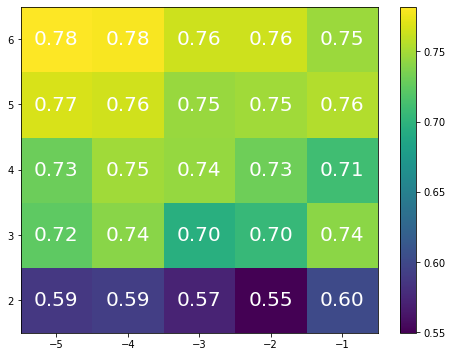

In [87]:
plt.figure(figsize=(8,6))
plt.pcolormesh(np.arange(-0.5, -6.5, -1), np.arange(1.5, 7.5), r2_scores_lasso);
for i in range(r2_scores_lasso.shape[0]):
    for j in range(r2_scores_lasso.shape[1]):
        plt.text(-1-j, i+2, f"{r2_scores_lasso[i][j]:.2f}",
                ha='center',va='center',
                size=20,color='w')
plt.colorbar();